# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Write the problem in your own words here

In [1]:
#import your libraries
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

#etc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#your info here
__author__ = "Alex EBE"
__email__ = "alexauguste01@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe
features = pd.read_csv('data/train_features.csv')
salaries = pd.read_csv('data/train_salaries.csv')

In [3]:
features.head(20)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


In [4]:
features.shape

(1000000, 8)

In [5]:
salaries.head(10)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163
5,JOB1362684407692,113
6,JOB1362684407693,178
7,JOB1362684407694,73
8,JOB1362684407695,31
9,JOB1362684407696,104


In [6]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


The dataset has :

- 2 numerical variables - `yearsExperience` and `milesFromMetropolis`;
- 6 categorical variables - `jobId`, `companyId`, `jobType`, `degree`, `major` and `industry`
- No missing values

### ---- 3 Clean the data ----

#### Removing duplicate

In [8]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
duplicate = features.duplicated(subset=['jobId'])
duplicated = duplicate[duplicate == True]
duplicated

Series([], dtype: bool)

#### Removing invalid data

In [9]:
#Invalid data
invalid_salaries = salaries.loc[salaries['salary']<=0,:]
invalid_job_offers = features.loc[invalid_salaries.index,:]
invalid_salaries #invalid data in outcome dataset

,jobId,salary
30559,JOB1362684438246,0
495984,JOB1362684903671,0
652076,JOB1362685059763,0
816129,JOB1362685223816,0
828156,JOB1362685235843,0


In [10]:
invalid_job_offers #invalid data in feature dataset

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29


In [11]:
salaries.drop(invalid_salaries.index, inplace=True)
features.drop(invalid_salaries.index, inplace=True)

#### Reset indexing

In [12]:
salaries.reset_index(inplace=True, drop=True)
features.reset_index(inplace=True, drop=True)

#### Remove irrelevant features

In [13]:
features.drop(['jobId', 'companyId'], axis=1, inplace=True)
salaries.drop(['jobId'], axis=1, inplace=True)

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999995 entries, 0 to 999994
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   jobType              999995 non-null  object
 1   degree               999995 non-null  object
 2   major                999995 non-null  object
 3   industry             999995 non-null  object
 4   yearsExperience      999995 non-null  int64 
 5   milesFromMetropolis  999995 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 45.8+ MB


In [15]:
numerical_features = ['yearsExperience', 'milesFromMetropolis']
categorical_features = ['jobType', 'degree', 'major', 'industry']

### ---- 4 Take a quick look at the data structure ----

In [16]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

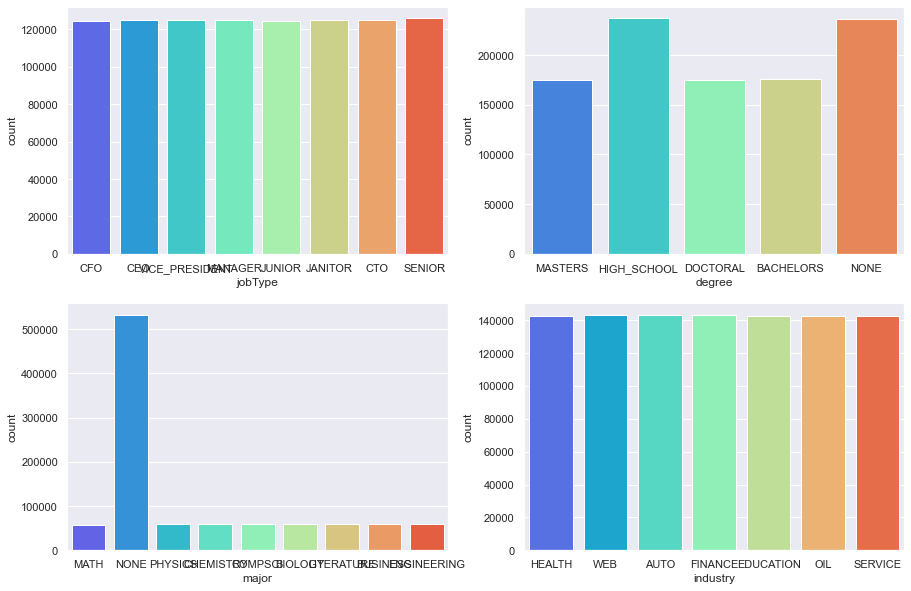

In [17]:
n = len(categorical_features)
plt.figure(figsize=(15,10))
#fig, axes =plt.subplots(len(categorical_features), 1)
for idx, feature in enumerate(categorical_features):
    plt.subplot(2, 2, idx + 1)
    sns.countplot(x=categorical_features[idx], data=features, palette='rainbow')
plt.show()

array([[<AxesSubplot:title={'center':'yearsExperience'}>,
        <AxesSubplot:title={'center':'milesFromMetropolis'}>]],
      dtype=object)

<Figure size 1440x720 with 0 Axes>

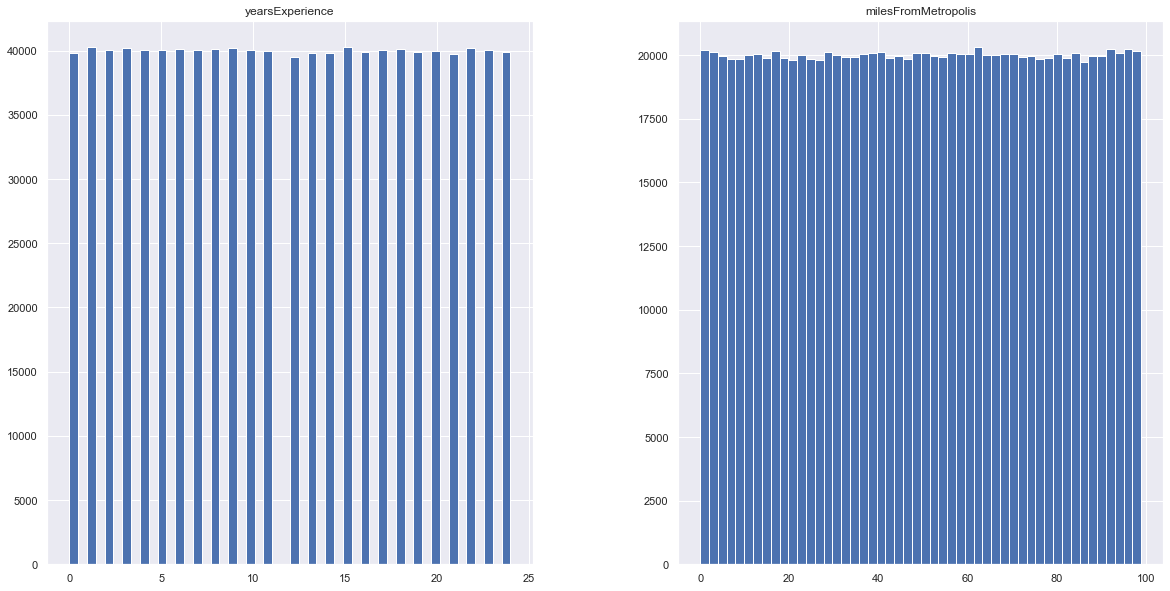

In [18]:
plt.figure(figsize=(20,10))
features.hist(bins=50, figsize=(20,10))

- **The distributions of years experience(`yearsExperience`) and miles form metropolis(`milesFromMetropolis`) are uniform**
- **The dataset is balanced regarding almost all features except `major` (more that 50% of the population has no major) and `degree` (`HIGH_SCHOOL` and `NONE` are the modes), but this reflects the reality that [around 50% of the US population attend to college](https://www.census.gov/newsroom/press-releases/2020/educational-attainment.html)** 

### ---- 6 Create a  test set ----

Before going further in data analysis, let's set aside part of the data. Although this decision seems hasty, it is useful to prevent us from data snooping bias.

We just pick some instances randomly, typically 20% of the dataset. Although the dataset is strongly imbalanced regarding the `major` feature, the population size prevents us from introducing sampling bias.

In [19]:
features_train, features_test, salaries_train, salaries_test = train_test_split(features, salaries, test_size=0.2, random_state=50)

### ---- 7 Explore the data (EDA) ----

In [20]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [21]:
features_train.describe(include='all')

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
count,799996,799996,799996,799996,799996.000000,799996.000000
unique,8,5,9,7,NaN,NaN
top,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN
freq,100763,189552,425764,114691,NaN,NaN
mean,NaN,NaN,NaN,NaN,11.994076,49.524638
std,NaN,NaN,NaN,NaN,7.211381,28.873037
min,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,6.000000,25.000000
50%,NaN,NaN,NaN,NaN,12.000000,50.000000
75%,NaN,NaN,NaN,NaN,18.000000,75.000000


In [22]:
salaries_train.describe(include='all')

,salary
count,799996.000000
mean,116.064437
std,38.722160
min,17.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


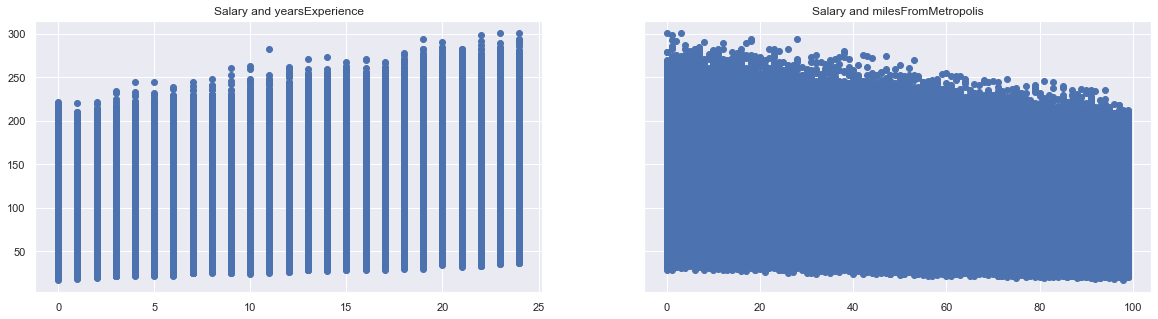

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(20,5))
ax1.scatter(features_train['yearsExperience'], salaries_train['salary'])
ax1.set_title('Salary and yearsExperience')
ax2.scatter(features_train['milesFromMetropolis'], salaries_train['salary'])
ax2.set_title('Salary and milesFromMetropolis')
plt.show()

##### Possible linear relationship between `salary` and `yearsExperience`

#### Distribution of salary

C:\anaconda3\envs\tf1\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


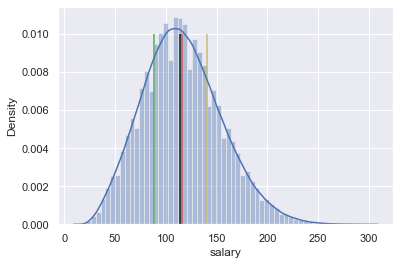

In [24]:
sns.distplot(salaries_train['salary'], bins=60)
plt.vlines([116, 114, 88, 141], colors=['r', 'k', 'g', 'y'], ymin=0, ymax=0.01)
#plt.vlines(114, colors='k', ymin=0, ymax=0.01)

##### The `salary` variable follows a normal distribution

In [25]:
corr_matrix = features_train.corr()
corr_matrix

,yearsExperience,milesFromMetropolis
yearsExperience,1.000000,-0.000671
milesFromMetropolis,-0.000671,1.000000


##### There's no linear correlation between the numerical features

#### Variability of salary by `jobType`, `degree`, `major` and `industry`

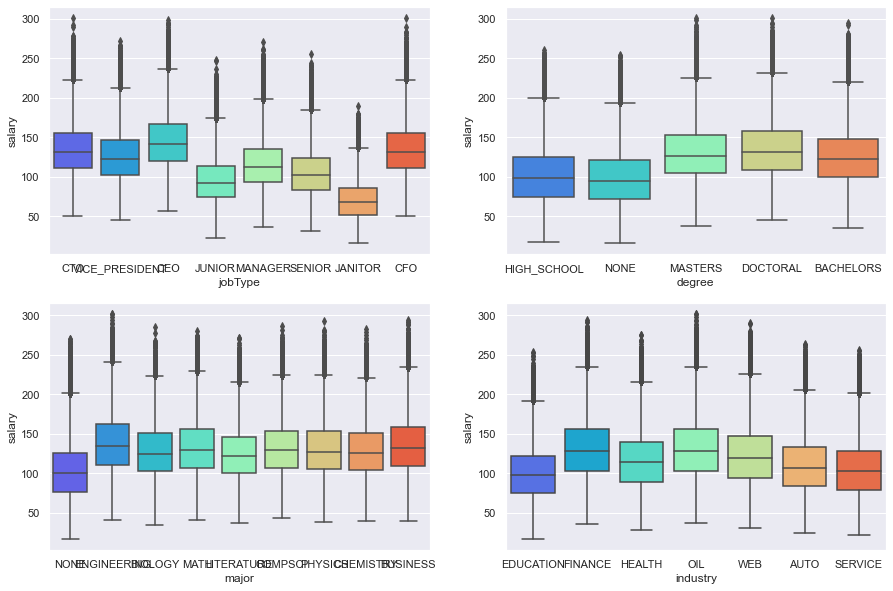

In [26]:
#f, ax = plt.subplots(2, 2, sharey=True)
plt.figure(figsize=(15,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=features_train[categorical_features[i]], y=salaries_train['salary'], palette='rainbow')

### ---- 9 Establish a baseline ----

#### Metric

We use MSE as metric

#### Baseline

Let's create a simple model which for a given job offer, use the average salary of the feature **jobType** as prediction. We make this choice because **jobType** feature shows more variability for the target feature.

In [27]:
def set_predictor():
    avg = {}
    for jobType in features_train['jobType'].unique():
        idx = features_train.loc[features_train['jobType']==jobType].index
        avg[jobType] = salaries_train.loc[idx,'salary'].mean() 
    return avg

In [28]:
set_predictor()

{'CTO': 135.49242197028772,
 'VICE_PRESIDENT': 125.34268149064852,
 'CEO': 145.32581189371572,
 'JUNIOR': 95.3856043449506,
 'MANAGER': 115.38478579768284,
 'SENIOR': 105.50264482002322,
 'JANITOR': 70.81678862763916,
 'CFO': 135.53591838377335}

In [29]:
def baseline_predict(X):
    avg_salary_by_jobType = set_predictor()
    return X['jobType'].map(avg_salary_by_jobType)

In [30]:
baseline_salaries_pred = baseline_predict(features_test)

In [31]:
baseline_salaries_pred

5462      135.535918
799101    135.492422
655329     70.816789
546844    145.325812
678291    135.492422
             ...    
107446    125.342681
394248    105.502645
187477     95.385604
229935    135.492422
292368    145.325812
Name: jobType, Length: 199999, dtype: float64

#### Baseline performance measure

In [32]:
baseline_score = sk.metrics.mean_squared_error(salaries_test['salary'], baseline_salaries_pred)

In [33]:
baseline_score

962.4720172032261

**Baseline MSE : 962.47** 

### ---- 10 Hypothesize solution ----

***We propose 3 models to improve the baseline model MSE:***
- ***Ridge regression, because there is a linear relationship between the features and the target ;***
- ***Voting ensemble by combining multiple linear regression;***
- ***Random forest*** 



***The categorical features will be changed to dummy variables***

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 11 Engineer features  ----

***This is feature engineering steps we take:***

- ***Standardizing numerical features;***

- ***One hot encoding categorical features.***

In [34]:
full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(sparse=False, drop='first'), categorical_features),
    ])

In [35]:
transformed_features_train = full_pipeline.fit_transform(features_train)
transformed_features_train.shape

(799996, 27)

### ---- 12 Create models ----

Ridge Regression

In [69]:
ridge_parameters =  {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 1e2, 1e3, 1e4, 5e4, 1e5, 6e5, 1e6]}
ridge_grid_search_cv = GridSearchCV(Ridge(), ridge_parameters, n_jobs=-1, verbose=2, cv=5)
ridge_grid_search_cv.fit(transformed_features_train, salaries_train)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1e-08, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005,
                                   0.001, 0.01, 0.1, 1.0, 100.0, 1000.0,
                                   10000.0, 50000.0, 100000.0, 600000.0,
                                   1000000.0]},
             verbose=2)

Random Forest

#####################""

In [ ]:
rf_parameters2 =  {"max_depth": [20, 25], "max_features":[20],
                            "max_leaf_nodes":[3500, 4000], "n_estimators": [200]}
rf_grid_search_cv2 = GridSearchCV(RandomForestRegressor(random_state=42), rf_parameters, n_jobs=-1, 
                                            verbose=5, cv=5, scoring='neg_mean_squared_error', refit=True)
rf_grid_search_cv2.fit(transformed_features_train, salaries_train['salary'].values)

############################"

In [39]:
rf_parameters =  {"max_depth": [20, 25], "max_features":[20],
                            "max_leaf_nodes":[3500, 4000], "n_estimators": [200]}
rf_grid_search_cv = GridSearchCV(RandomForestRegressor(random_state=42), rf_parameters, n_jobs=-1, 
                                            verbose=5, cv=5, scoring='neg_mean_squared_error', refit=True)
rf_grid_search_cv.fit(transformed_features_train, salaries_train['salary'].values)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20, 25], 'max_features': [20],
                         'max_leaf_nodes': [3500, 4000],
                         'n_estimators': [200]},
             scoring='neg_mean_squared_error', verbose=5)

In [40]:
#2nd CV
rf_grid_search_cv.best_estimator_

RandomForestRegressor(max_depth=20, max_features=20, max_leaf_nodes=4000,
                      n_estimators=200, random_state=42)

In [40]:
rf_grid_search_cv.best_score_

-374.1915582362074

In [143]:
ridge_grid_search_cv.best_estimator_

Ridge()

Gradient Boosting

In [87]:
#gb_parameters =  {"max_depth": [20, 25], "max_features":[20, 23, 25, 27],
#                     "max_leaf_nodes":[6000],        }
#gb_grid_search_cv = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_parameters, n_jobs=-1, 
#                                            verbose=5, cv=3, scoring='neg_mean_squared_error', refit=True)
#gb_grid_search_cv.fit(transformed_features_train, salaries_train['salary'].values)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [20, 25],
                         'max_features': [20, 23, 25, 27],
                         'max_leaf_nodes': [6000]},
             scoring='neg_mean_squared_error', verbose=5)

In [36]:
data_dmatrix = xgb.DMatrix(data=transformed_features_train,label=salaries_train)

gb_parameters =  {"max_depth": [5, 7], "alpha":[0.0001], "colsample_bytree": [0.1,], 
                  "n_estimators":[2000, 2500],  
                  "learning_rate":[0.5]}   
gb_rand_search_cv = GridSearchCV(xgb.XGBRegressor(objective="reg:squarederror", seed=123, 
                                                  early_stopping_rounds=20,), gb_parameters, n_jobs=-1, 
                                        verbose=5, cv=5, scoring='neg_mean_squared_error', refit=True)
gb_rand_search_cv.fit(transformed_features_train, salaries_train['salary'].values)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(early_stopping_rounds=20,
                                    objective='reg:squarederror', seed=123),
             n_jobs=-1,
             param_grid={'alpha': [0.0001], 'colsample_bytree': [0.1],
                         'learning_rate': [0.5], 'max_depth': [5, 7],
                         'n_estimators': [2000, 2500]},
             scoring='neg_mean_squared_error', verbose=5)

In [37]:
gb_rand_search_cv.best_estimator_

XGBRegressor(alpha=0.0001, colsample_bytree=0.1, early_stopping_rounds=20,
             learning_rate=0.5, max_depth=5, n_estimators=2500,
             objective='reg:squarederror', seed=123)

In [38]:
gb_rand_search_cv.best_score_

-356.19516631466365

### ---- 13 Test models ----

In [ ]:
transformed_features_test = full_pipeline.fit_transform(features_test)

Ridge regression

In [137]:
ridge_salaries_pred = ridge_grid_search_cv.predict(transformed_features_test)

In [138]:
ridge_score = sk.metrics.mean_squared_error(salaries_test['salary'], ridge_salaries_pred)

In [139]:
ridge_score

383.0554213546274

Random Forest

In [43]:
rf_pred = rf_grid_search_cv.predict(transformed_features_test)

In [44]:
rf_score = sk.metrics.mean_squared_error(salaries_test['salary'], rf_pred)

In [45]:
rf_score

373.0492452140269

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data